In [1]:
%%bash
pip install cartopy > /dev/null
pip install xarray > /dev/null

mkdir storm_mode
cd storm_mode
wget -nc -q https://raw.githubusercontent.com/ahaberlie/unidata-workshop-2018/refs/heads/master/workshop/data/training/sample_train_data.csv
wget -nc -q https://raw.githubusercontent.com/ahaberlie/unidata-workshop-2018/refs/heads/master/workshop/data/training/sample_test_data.csv

# Chapter 8.2 - Clustering

[Clustering (or Cluster Analysis](https://en.wikipedia.org/wiki/Cluster_analysis) describes a group of unsupervised machine learning techniques. The purpose of these techniques is to organize unlabled samples (and their associated feature vectors) into meaningful groups. Ideal groups will promote within group similarity and between group differences.

There are many clustering algorithms, but in this chapter we will focus on the following:

1. [k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering)
2. [Self-organizing map](https://en.wikipedia.org/wiki/Self-organizing_map)

### Chapter 8.2.1 - k-means clustering

This clustering approach uses "cluster centers" to partition the data into groups. The user (e.g., you) decides how many cluster centers to use and the algorithm generates these points within the existing parameter space (determined from the samples). Then, each sample is assigned to "closest" cluster sample. The centroid of each cluster is found, which serves as the "new" cluster center. This process is repeated until some condition is met. For example, you might set a maximum amount of times the center is recalculated, or you may have a threshold that determines the minimum amount of samples that change groups.

The "closest" cluster center can be determined in a number of ways, but the easiest to understand is [euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance).

The best way to initially think about it is in terms of geographic distances. Imagine that you picked two "cluster centers" that corresponded to the latitude / longitude positions of Des Moines, IA and Chicago, IL. If you have a sample for DeKalb, IL, what "cluster center" is closer? You should probably immediately recognize that Chicago is closer to DeKalb than Des Moines, but how can you quantify this difference?

The code below demonstrates how the nearest "cluster center" is defined if `latitude` and `longitude` were features, and the feature vector contained those two variables for each sample. We will first use the basic distance calculation.

$d = sqrt((x1 - x2)^{2} + (y1 - y2)^{2})$

In [2]:
import numpy as np

chi = np.array([41.88, -87.63])
dsm = np.array([41.59, -93.62])

dkb = np.array([41.93, -88.75])

distance_chi = np.sqrt((dkb[0] - chi[0])**2 + (dkb[1] - chi[1])**2)
distance_dsm = np.sqrt((dkb[0] - dsm[0])**2 + (dkb[1] - dsm[1])**2)

print("DKB -> CHI", distance_chi)
print("DKB -> DSM", distance_dsm)

DKB -> CHI 1.1211155159036958
DKB -> DSM 4.881854155953457


However, since the square root calculation can be expensive, we can remove that and get the "same" result--specifically, finding the nearest cluster center.

*Your Turn*: Based on the results, what cluster center should you assign DeKalb, IL?



In [3]:
distance_chi = (dkb[0] - chi[0])**2 + (dkb[1] - chi[1])**2
distance_dsm = (dkb[0] - dsm[0])**2 + (dkb[1] - dsm[1])**2

print("DKB -> CHI (squared distance)", distance_chi)
print("DKB -> DSM (squared distance)", distance_dsm)

DKB -> CHI (squared distance) 1.25690000000001
DKB -> DSM (squared distance) 23.832500000000042


**Storm morphology clustering**

In the previous chapter, we introduced the storm morphology classification dataset. We can demonstrate k-means clustering on those data.

First, we should visualize the two variables we found most useful for separating the labels in the last chapter.

*Your Turn*: think about locations (coordinates) that you think would serve as good cluster centers. Why?

<Axes: xlabel='mean_intensity', ylabel='major_axis_length'>

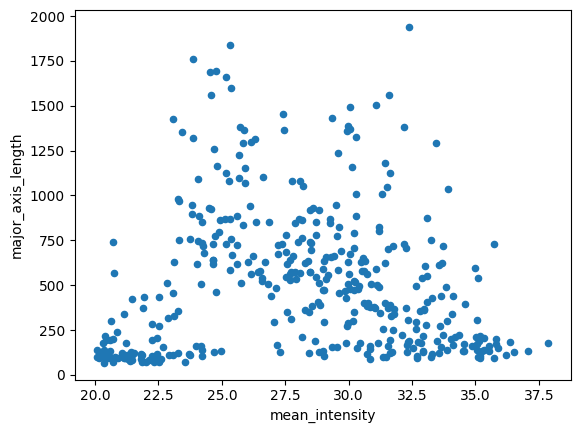

In [4]:
import pandas as pd

df = pd.read_csv("storm_mode/sample_train_data.csv")

numeric_cols = df.select_dtypes(include="number").columns.tolist()
numeric_cols.remove('index')
numeric_cols.remove('label')
numeric_cols.remove('label1')

df.plot(kind='scatter', x='mean_intensity', y='major_axis_length')

Next, we are going to split the data into a `training` subset of samples and a `validation` subset of samples. We can generate the machine learning model using the `training` samples, and then [pick our best model](https://en.wikipedia.org/wiki/Model_selection) using the `validation` samples.

In this way, we can keep the `testing` dataset clean (more on that in a second) and run experiments to pick the model we think will perform the best on previously unseen data.

We can use sklearn's `train_test_split` function:

In [5]:
from sklearn.model_selection import train_test_split

# even though this is "test_size" it is coming from the training data in 'df'
df_train, df_val = train_test_split(df, test_size=0.1, train_size=0.9)

print("# training samples =", len(df_train))
print("# validation samples =", len(df_val))

# training samples = 359
# validation samples = 40


**`sklearn.clustering.KMeans`**

We can set up the [`KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) model from sklearn using the following class methods and properties.

The `KMeans` class constructor (i.e., ``__init__``) has several arguments, including:

- `n_clusters`: number of clusters to generate
- `random_state`: makes the "random" state repeatable by providing an integer value

The `kmeans` class instance has several properties, including

- `cluster_centers_` - the location (in feature space) of the cluster centers
- `labels_` - the labels for all of the input points (in the same order as the original samples)
- `interia_` - distances of each sample to their assigned `cluster_centers_`
- `n_features_in_` - size of the feature vector for each sample

*Your Turn*: Modify the clustering result by changing the two variables used for clustering and the `KMeans` parameters for the `kmean` instance. What are some things you notice when modifying each parameter? What is the impact (if any) of selecting to normalize (z-score) the data?

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import ipywidgets as widgets
from IPython.display import display, clear_output
from matplotlib.colors import ListedColormap

OKABE_ITO = [
    "#000000", "#E69F00", "#56B4E9", "#009E73",
    "#F0E442", "#0072B2", "#D55E00", "#CC79A7"
]
cmap_okabe = ListedColormap(OKABE_ITO)

x_dd = widgets.Dropdown(options=numeric_cols, value=numeric_cols[0], description="X:")
y_dd = widgets.Dropdown(options=numeric_cols, value=numeric_cols[1], description="Y:")

k_slider = widgets.IntSlider(value=3, min=1, max=8, step=1, description="K:", continuous_update=False)
seed_box = widgets.IntText(value=0, description="seed:")
ninit_box = widgets.IntText(value=10, description="n_init:")

use_zscore = widgets.Checkbox(value=False, description="Z-score normalize (fit on df_train)")
show_val_names = widgets.Checkbox(value=True, description="Show label_name (df_val only)")
max_labels = widgets.IntSlider(value=5, min=0, max=40, step=5, description="Max labels:", continuous_update=False)

out = widgets.Output()

def _subset_indices(n_total, n_keep, seed):
    if n_keep >= n_total:
        return np.arange(n_total)
    rng = np.random.default_rng(seed)
    return rng.choice(n_total, size=n_keep, replace=False)

def plot_kmeans_train_val(xcol, ycol, K, seed, n_init, zscore, show_label_name_val, max_n_labels):
    if xcol == ycol:
        with out:
            clear_output(wait=True)
            print("Pick two different features for X and Y.")
        return

    Xtr_raw = df_train[[xcol, ycol]].to_numpy(dtype=np.float64)
    Xva_raw = df_val[[xcol, ycol]].to_numpy(dtype=np.float64)

    if zscore:
        scaler = StandardScaler()
        Xtr = scaler.fit_transform(Xtr_raw)
        Xva = scaler.transform(Xva_raw)
    else:
        Xtr, Xva = Xtr_raw, Xva_raw

    with out:
        clear_output(wait=True)

        km = KMeans(n_clusters=K, n_init=n_init, random_state=seed).fit(Xtr)

        ytr = km.labels_
        yva = km.predict(Xva)

        centers = km.cluster_centers_

        fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharex=True, sharey=True)

        axes[0].scatter(
            Xtr[:, 0], Xtr[:, 1],
            c=ytr, cmap=cmap_okabe, vmin=-0.5, vmax=K-0.5,
            s=28, alpha=0.85, edgecolors="k", linewidths=0.25
        )
        axes[0].plot(centers[:, 0], centers[:, 1], "kx", markersize=10, label="cluster center")
        axes[0].set_title(f"TRAIN (fit) — K={K}")
        axes[0].legend(loc="best")

        axes[1].scatter(
            Xva[:, 0], Xva[:, 1],
            c=yva, cmap=cmap_okabe, vmin=-0.5, vmax=K-0.5,
            s=28, alpha=0.85, edgecolors="k", linewidths=0.25
        )
        axes[1].plot(centers[:, 0], centers[:, 1], "kx", markersize=10, label="cluster center")
        axes[1].set_title(f"VAL (predict) — K={K}")

        if show_label_name_val and ("label_name" in df_val.columns) and max_n_labels > 0:
            idx = _subset_indices(len(df_val), min(max_n_labels, len(df_val)), seed)
            for i in idx:
                axes[1].annotate(
                    str(df_val["label_name"].iloc[i]),
                    (Xva[i, 0], Xva[i, 1]),
                    xytext=(3, 3), textcoords="offset points",
                    fontsize=8, alpha=0.8
                )

        xlabel = f"{xcol}" + (" (z)" if zscore else "")
        ylabel = f"{ycol}" + (" (z)" if zscore else "")
        axes[0].set_xlabel(xlabel); axes[1].set_xlabel(xlabel)
        axes[0].set_ylabel(ylabel)

        plt.tight_layout()
        plt.show()
    return km


ui = widgets.VBox([
    widgets.HBox([x_dd, y_dd, k_slider, seed_box, ninit_box]),
    widgets.HBox([use_zscore, show_val_names, max_labels]),
])

In [7]:

display(ui, out)

widgets.interactive_output(
    plot_kmeans_train_val,
    {
        "xcol": x_dd,
        "ycol": y_dd,
        "K": k_slider,
        "seed": seed_box,
        "n_init": ninit_box,
        "zscore": use_zscore,
        "show_label_name_val": show_val_names,
        "max_n_labels": max_labels,
    },
)


Output()

Output()

Once you have selected your "perfect" clustering approach, we can test the data on an independent dataset. We do this to test the [generalizability](https://en.wikipedia.org/wiki/External_validity) of the model.

These are some assumptions we can make when using separate `training` (and `val`) and `testing` datasets:

1. None of the data from the `testing` dataset were used to create the model
2. The `testing` and `training` datasets are representative of the [population](https://en.wikipedia.org/wiki/Statistical_population)
2. If the `testing` and `training` datasets are independent*, performance on the `testing` dataset is an indicator of performance over the population

*Independence can be easily achieved using temporal splitting ("leave one year out", etc.) *Think about it*: Why would this make the samples independent if they are from different years? Why would randomly grabbing samples from the same year potentially influence your performance?

We conveniently have labeled data, so we can directly examine the performance of your chosen `KMeans` model.

*Think about it*: Do the datapoints look like they could be from the same "population" as the training data?

<Axes: xlabel='mean_intensity', ylabel='major_axis_length'>

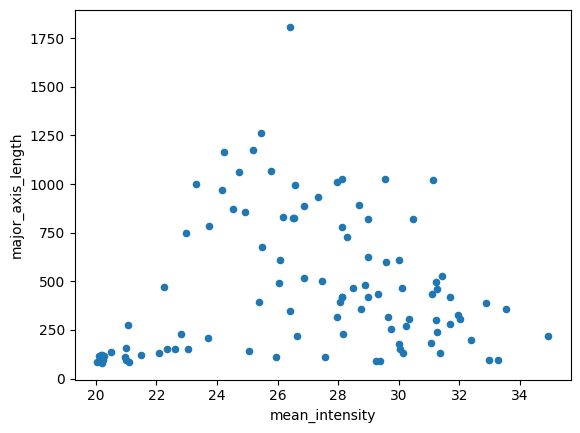

In [8]:
import pandas as pd

df_test = pd.read_csv("storm_mode/sample_test_data.csv")

numeric_cols = df_test.select_dtypes(include="number").columns.tolist()
numeric_cols.remove('index')
numeric_cols.remove('label')
numeric_cols.remove('label1')

df_test.plot(kind='scatter', x='mean_intensity', y='major_axis_length')

Let's see how many unique labels exist in the dataset. If this differs from your model above, change it now!

In [9]:
df_test['label_name'].nunique()

5

We can ask the `KMeans` model to predict what cluster each sample belongs to. Just make sure to set your `var1` and `var2` below to match with your model above.

In [10]:
var1 = 'mean_intensity'
var2 = 'solidity'

num_cluster = 5
seed = 0
n_init = 10

df_train_x = df_train[[var1, var2]].to_numpy(dtype=np.float64)
df_test_x = df_test[[var1, var2]].to_numpy(dtype=np.float64)

kmeans = KMeans(n_clusters=num_cluster, n_init=n_init, random_state=seed).fit(df_train_x)

# the KMeans trained instance predicts the cluster
preds = kmeans.predict(df_test_x)

preds

array([0, 4, 3, 3, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 4, 3, 4, 0, 0, 0, 0, 3,
       0, 0, 4, 4, 0, 0, 4, 0, 4, 0, 0, 2, 4, 2, 0, 3, 2, 0, 4, 4, 4, 4,
       4, 2, 4, 4, 0, 4, 2, 4, 4, 4, 4, 4, 4, 2, 4, 0, 2, 2, 4, 2, 4, 2,
       1, 2, 2, 2, 2, 2, 4, 2, 1, 4, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

Results:

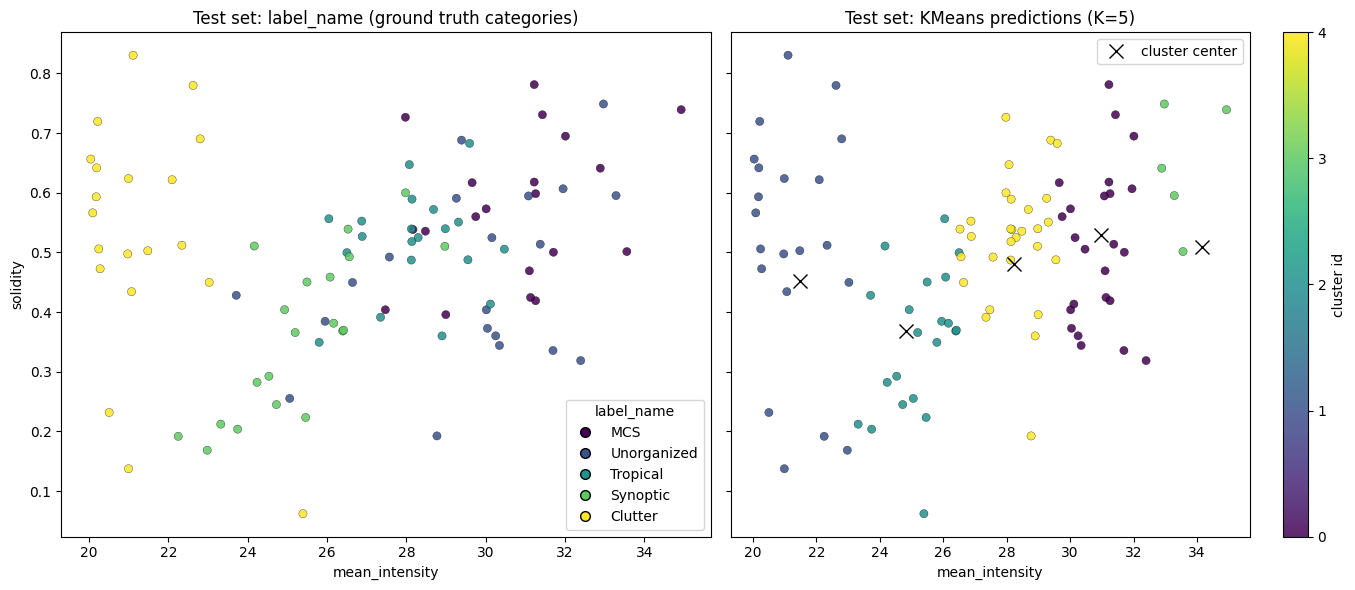

In [11]:
import numpy as np
import matplotlib.pyplot as plt

centers = kmeans.cluster_centers_

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

name_codes, name_levels = pd.factorize(df_test["label_name"])

sc0 = axes[0].scatter(
    df_test[var1], df_test[var2],
    c=name_codes,
    s=35, alpha=0.85,
    edgecolors="k", linewidths=0.25
)
axes[0].set_title("Test set: label_name (ground truth categories)")
axes[0].set_xlabel(var1)
axes[0].set_ylabel(var2)

handles0 = []
for code, name in enumerate(name_levels):
    handles0.append(plt.Line2D([0], [0], marker="o", linestyle="",
                               markerfacecolor=sc0.cmap(sc0.norm(code)),
                               markeredgecolor="k", markersize=7, label=str(name)))
if len(handles0) <= 15:
    axes[0].legend(handles=handles0, title="label_name", loc="best")

sc1 = axes[1].scatter(
    df_test[var1], df_test[var2],
    c=preds,
    s=35, alpha=0.85,
    edgecolors="k", linewidths=0.25
)
axes[1].plot(centers[:, 0], centers[:, 1], "kx", markersize=10, label="cluster center")
axes[1].set_title(f"Test set: KMeans predictions (K={num_cluster})")
axes[1].set_xlabel(var1)
axes[1].legend(loc="best")

cbar = fig.colorbar(sc1, ax=axes[1], ticks=np.arange(num_cluster))
cbar.set_label("cluster id")

plt.tight_layout()
plt.show()


**Lab 6 will further explore performance metrics using these datasets**